In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time
import os

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def loadNpy(filename):
    with open(filename, "rb") as f: return np.load(f)

db = f"{os.getcwd()}/../data2/slices/gaussian-grabber/size343000-Dstd-div2/"
data_type = "s-"

In [4]:
X_train, X_val, X_test = loadNpy(db + f"X_train.npy"), loadNpy(db + f"X_val.npy"), loadNpy(db + f"X_test.npy")
y_train, y_val, y_test = loadNpy(db + f"{data_type}y_train.npy"), loadNpy(db + f"{data_type}y_val.npy"), loadNpy(db + f"{data_type}y_test.npy")

In [5]:
def npy_to_tensor(data, l=False):
    if not l:
        data = torch.from_numpy(data).float()
    else:
        data = torch.from_numpy(data).type(torch.LongTensor)
    return data

In [6]:
X_train, X_val, X_test = npy_to_tensor(X_train), npy_to_tensor(X_val), npy_to_tensor(X_test)
y_train, y_val, y_test = npy_to_tensor(y_train, 1), npy_to_tensor(y_val, 1), npy_to_tensor(y_test, 1)

In [7]:
batch_size = 8

In [8]:
train_dataset = TensorDataset(X_train, y_train)

val_dataset = TensorDataset(X_val, y_val)

test_dataset = TensorDataset(X_test, y_test)

# Data loader
train_iterator = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=False)

val_iterator = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

test_iterator = DataLoader(dataset=test_dataset, batch_size=batch_size,shuffle=False)

In [41]:
X_train.shape

torch.Size([60, 70, 70, 70])

In [10]:
np.mean(y_train)

TypeError: mean() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, dtype=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


In [82]:
np.mean(y_val)

0.65

In [83]:
np.mean(y_test)

0.45

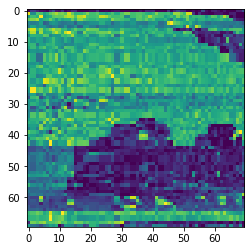

In [84]:
image = X_train[4,:]
plt.imshow(image[20,:,:])

In [107]:
for i in range(X_train.shape[0]):
    sample = X_train[i,:,:,:]
    print(sample)

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.3846, 0.5000, 0.3538,  ..., 0.1846, 0.2077, 0.4000],
         ...,
         [0.0000, 0.0000, 0.5000,  ..., 0.0000, 0.0000, 0.5000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.4135, 0.1579, 0.0451,  ..., 0.1955, 0.0075, 0.0226],
         [0.5536, 0.6071, 0.1339,  ..., 0.6071, 0.3304, 0.2321],
         ...,
         [0.1526, 0.4579, 0.7526,  ..., 0.4632, 0.4789, 0.5211],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.2500,  ..., 0.7500, 0.2500, 0.7500],
         [0.5092, 0.3926, 0.0491,  ..., 0.2393, 0.3804, 0.1043],
         [0.1364, 0.2898, 0.1420,  ..., 0.1023, 0.3580, 0.

tensor([[[0.4688, 0.3438, 0.3229,  ..., 0.3542, 0.0000, 0.4896],
         [0.1550, 0.4031, 0.3643,  ..., 0.0698, 0.1473, 0.1938],
         [0.4383, 0.2716, 0.3642,  ..., 0.1358, 0.0370, 0.2778],
         ...,
         [0.6758, 0.6593, 0.6209,  ..., 0.4615, 0.3077, 0.2363],
         [0.0476, 0.1095, 0.1286,  ..., 0.6429, 0.6143, 0.2381],
         [0.2913, 0.3386, 0.3150,  ..., 0.5512, 0.0945, 0.5512]],

        [[0.4196, 0.2411, 0.2143,  ..., 0.0893, 0.0268, 0.1429],
         [0.2477, 0.7064, 0.7798,  ..., 0.4495, 0.5596, 0.2018],
         [0.0063, 0.0188, 0.0188,  ..., 0.0625, 0.1813, 0.1562],
         ...,
         [0.3631, 0.2849, 0.3575,  ..., 0.4469, 0.4413, 0.4413],
         [0.9835, 0.8516, 0.5440,  ..., 0.2692, 0.5055, 0.5110],
         [0.3500, 0.1750, 0.1917,  ..., 0.4917, 0.0750, 0.2667]],

        [[0.0345, 0.0603, 0.1293,  ..., 0.1121, 0.3621, 0.0431],
         [0.2662, 0.4317, 0.4892,  ..., 0.1079, 0.3094, 0.1655],
         [0.0909, 0.1399, 0.3566,  ..., 0.0979, 0.1748, 0.

In [29]:
X_test.shape

(60, 343000)

In [9]:
input_size = 343000
h1_size = 800
h2_size = 800
h3_size = 400
h4_size = 200
h5_size = 100
num_classes = 2
num_epochs = 1000
batch_size = 8
learning_rate = 0.001

In [10]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, h1_size).to(device)
        #self.bn1 = nn.BatchNorm1d(h1_size)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(h1_size, h2_size).to(device)
        #self.bn2 = nn.BatchNorm1d(h2_size)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(p=0.5)
        
        #self.drop1 = nn.Dropout(p=0.1)
        #self.bn2 = nn.BatchNorm1d(h2_size)
        self.fc3 = nn.Linear(h2_size, h3_size).to(device)
        #self.bn3 = nn.BatchNorm1d(h3_size)
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(p=0.5)
        
        #self.bn3 = nn.BatchNorm1d(h3_size)
        self.fc4 = nn.Linear(h3_size, h4_size).to(device)
        #self.bn4 = nn.BatchNorm1d(h4_size)
        self.relu4 = nn.ReLU()
        self.drop4 = nn.Dropout(p=0.5)
        
        #self.bn4 = nn.BatchNorm1d(h4_size)
        #self.drop2 = nn.Dropout(p=0.1)
        self.fc5 = nn.Linear(h4_size, h5_size).to(device)
        #self.bn5 = nn.BatchNorm1d(h4_size)
        self.relu5 = nn.ReLU()
        self.drop5 = nn.Dropout(p=0.5)
        
        self.fc6 = nn.Linear(h5_size, num_classes).to(device)
    
    def forward(self, x):
        out = self.fc1(x)
        #out = self.bn1(out)
        out = self.relu1(out)
        out = self.drop1(out)
        
        out = self.fc2(out)
        #out = self.bn2(out)
        out = self.relu2(out)
        out = self.drop2(out)
        
        #out = self.bn2(out)
        out = self.fc3(out)
        #out = self.bn3(out)
        out = self.relu3(out)
        out = self.drop3(out)
        #out = self.bn3(out)
        
        out = self.fc4(out)
        #out = self.bn4(out)
        out = self.relu4(out)
        out = self.drop4(out)
        
        #out = self.bn4(out)
        out = self.fc5(out)
        #out = self.bn5(out)
        out = self.relu5(out)
        out = self.drop5(out)
        
        out = self.fc6(out)
        return out

In [11]:
def eval_nn(mod, data):
    preds = []
    actual = []
    
    shape = data.dataset.tensors[0].shape[1:]
    
    mod.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in data:
            images = images.reshape(-1, 343000).to(device)
            labels = labels.to(device)
            outputs = mod(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            preds.append(predicted)
            actual.append(labels)

        print(f'Accuracy of the network on the {total} test images: {100 * correct / total} %')
    return preds, actual, correct/total

In [12]:
nn_model = NeuralNet(input_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate, weight_decay=1e-3)

In [13]:
nn_epochs = {}

# Train the model
total_step = len(train_iterator)
for epoch in tqdm(range(num_epochs)):
    for i, (images, labels) in enumerate(train_iterator):  
        # Move tensors to the configured device
        #print(images.shape)
        images = images.reshape(-1, 343000).to(device)
        labels = labels.to(device)
        
        # Forward pass
        #print(images.shape)
        outputs = nn_model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        
        #torch.nn.utils.clip_grad_norm_(nn_model.parameters(), 5)
        optimizer.step()
        #print(i)

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    nn_epochs[epoch] = {"loss": loss.item(), "train": eval_nn(nn_model, train_iterator), 
                 "val": eval_nn(nn_model, val_iterator), "test": eval_nn(nn_model, test_iterator)}
    nn_model.train()

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/1000], Step [150/150], Loss: 2.5830
Accuracy of the network on the 1200 test images: 84.58333333333333 %
Accuracy of the network on the 400 test images: 86.75 %
Accuracy of the network on the 400 test images: 84.25 %
Epoch [2/1000], Step [150/150], Loss: 0.8817
Accuracy of the network on the 1200 test images: 84.58333333333333 %
Accuracy of the network on the 400 test images: 86.75 %
Accuracy of the network on the 400 test images: 84.25 %
Epoch [3/1000], Step [150/150], Loss: 0.8909
Accuracy of the network on the 1200 test images: 84.58333333333333 %
Accuracy of the network on the 400 test images: 86.75 %
Accuracy of the network on the 400 test images: 84.25 %
Epoch [4/1000], Step [150/150], Loss: 0.7896
Accuracy of the network on the 1200 test images: 84.58333333333333 %
Accuracy of the network on the 400 test images: 86.75 %
Accuracy of the network on the 400 test images: 84.25 %
Epoch [5/1000], Step [150/150], Loss: 1.3912
Accuracy of the network on the 1200 test images: 84

KeyboardInterrupt: 

In [ ]:
eval_nn(nn_model, val_iterator)

In [14]:
loaders = {
    'train': train_iterator,
    'val': val_iterator,
    'test': test_iterator
}

In [27]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=70,              
                out_channels=64,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),
            #nn.BatchNorm2d(16),
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        ).to(device)
        self.conv2 = nn.Sequential(         
            nn.Conv2d(64, 128, 5, 1, 2),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.Dropout(p=0.1),
            nn.MaxPool2d(2),                
        ).to(device)
        self.conv3 = nn.Sequential(         
            nn.Conv2d(128, 256, 5, 1, 2),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.Dropout(p=0.1),
            #nn.MaxPool2d(2),
        ).to(device)
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 128, 5, 1, 2),
            nn.ReLU(),
            #nn.Dropout(p=0.1),
            nn.MaxPool2d(2),
        ).to(device)
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 128, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        ).to(device)
        self.conv6 = nn.Sequential(
            nn.Conv2d(128, 512, 5, 1, 2),
            nn.ReLU(),
            #nn.Dropout(p=0.1)
            #nn.MaxPool2d(2),
        ).to(device)
        self.conv7 = nn.Sequential(
            nn.Conv2d(512, 256, 5, 1, 2),
            nn.ReLU(),
            #nn.MaxPool2d(2),
        ).to(device)
        self.conv8 = nn.Sequential(         
            nn.Conv2d(256, 128, 5, 1, 2),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.Dropout(p=0.1),
            #nn.MaxPool2d(2),                
        ).to(device)
        self.conv9 = nn.Sequential(         
            nn.Conv2d(128, 512, 5, 1, 2),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.Dropout(p=0.1),
            #nn.MaxPool2d(3),
        ).to(device)
        self.conv10 = nn.Sequential(
            nn.Conv2d(512, 128, 5, 1, 2),
            nn.ReLU(),
            #nn.Dropout(p=0.1),
            nn.MaxPool2d(2),
        ).to(device)
        self.conv11 = nn.Sequential(
            nn.Conv2d(128, 64, 5, 1, 2),
            nn.ReLU(),
        ).to(device)
        # fully connected layer, output 10 classes
        self.out = nn.Linear(256, 2).to(device)
        
        
    def forward(self, x):
        x = x.to(device)
        #print(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.conv11(x)
        
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        output = self.out(x)
        return output, x    # return x for visualization

In [38]:
from torchmetrics import ROC

def eval_cnn(cnn_mod, data):
    
    cnn_mod.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        pred_ys = []
        labs = []
        for images, labels in loaders[data]:
            images = images.to(device)
            labels = labels.to(device)
            test_output, last_layer = cnn_mod(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            pred_ys = pred_ys + test_output.flatten().tolist()
            labs = labs + labels.tolist()
            total += len(labels)
            correct += (pred_y == labels).sum().item()
            pass
        print(f'{data} Accuracy of the model on the {total} {data} images: %.3f' % (correct/total))
        return pred_ys, labs, correct/total
    pass

In [39]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(70, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv6): Sequential(
    (0): Conv2d(128, 512, kernel_size=(

In [40]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [41]:
optimizer = optim.Adam(cnn.parameters(), lr = 0.001)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [46]:
from torch.autograd import Variable

num_epochs = 1000
cnn_epochs = {}

def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in tqdm(range(num_epochs)):
        for i, (images, labels) in enumerate(loaders['train']):
            
            images = images.to(device)
            labels = labels.to(device)
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            #print(i)
            if (i+1) % 150 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                cnn_epochs[epoch] = {"loss": loss.item(), "train": eval_cnn(cnn, "train"), 
                             "val": eval_cnn(cnn, "val"), "test": eval_cnn(cnn, "test")}
                cnn.train()
                pass
        pass
    pass

train(num_epochs, cnn, loaders)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/1000], Step [150/150], Loss: 5.7132
train Accuracy of the model on the 1200 train images: 0.846
val Accuracy of the model on the 400 val images: 0.868
test Accuracy of the model on the 400 test images: 0.843
Epoch [2/1000], Step [150/150], Loss: 5.5312
train Accuracy of the model on the 1200 train images: 0.846
val Accuracy of the model on the 400 val images: 0.868
test Accuracy of the model on the 400 test images: 0.843
Epoch [3/1000], Step [150/150], Loss: 5.3331
train Accuracy of the model on the 1200 train images: 0.846
val Accuracy of the model on the 400 val images: 0.868
test Accuracy of the model on the 400 test images: 0.843
Epoch [4/1000], Step [150/150], Loss: 5.1284
train Accuracy of the model on the 1200 train images: 0.846
val Accuracy of the model on the 400 val images: 0.868
test Accuracy of the model on the 400 test images: 0.843
Epoch [5/1000], Step [150/150], Loss: 4.9068
train Accuracy of the model on the 1200 train images: 0.846
val Accuracy of the model o

KeyboardInterrupt: 

In [28]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)      

NameError: name 'partial' is not defined